Produce z500 anomaly (June-Oct) maps for each WT  
 - 1 Compute climatology
 - 2 Compute anomaly of WT
 - 3 Plotting 

In [3]:
import sys
import datetime
import calendar
import numpy as np
import pandas as pd
from pandas.tseries.offsets import MonthEnd
import xarray as xr
import cfgrib
import matplotlib.pyplot as plt
import glob 
import os.path
import cartopy 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# inorder to import my pathon module, add
# $PYTHONPATH for jupyter for module
sys.path.append("/glade/u/home/mingge/PYTHON")
import coexist_func 
from importlib import reload
reload(coexist_func)
from coexist_func import plot_single
from coexist_func import find_year_top25_wt_smyle
from coexist_func import cal_seasonalmean_wt_smyle
from coexist_func import cal_season_std_smyle
from coexist_func import cal_season_cli_smyle 
from coexist_func import cal_season_ano_smyle
from coexist_func import ax_coastlines_country
from coexist_func import plot_prec_12

In [4]:
level_s = np.array([0, 1, 2.5, 5, 7.5, 10, 15, 20,25, 37.5, 50,
         75, 100, 125, 150, 200, 250, 300, 400, 500, 600, 750])

# declares a recentered projection for Pacific areas
proj = ccrs.PlateCarree(central_longitude=180)

def ax_coastlines_country(ax_s):
    ax_s.coastlines(linewidths=0.5)
    ax_s.add_feature(cfeature.NaturalEarthFeature(category='cultural',
                                           name='admin_0_countries',
                                           scale='10m',
                                           facecolor='none',
                                           edgecolor='black',
                                           linewidth=0.2))

def plot_S2Swt_12(prec, min_v, max_v, n_lev, cmap_s, colorbar_ori, title_s):
    '''
    prec(12,nlat, nlon): 3d variable to plot
    colorbar_ori: colorbar orientation, verticle or horizontal
    title_s: the common title for subplot
    '''
    # relableed WT: 0=Monsoon, 1=Normal, 2=Dry
    wt_s = ['Monsoon', 'Normal', 'Dry']
    
    fig = plt.figure(figsize=(22,12))
    
    cnlevel = np.linspace(min_v, max_v, num=n_lev)
  
    for nr in range(prec.shape[0]):
        for wt in range(prec.shape[1]):
            col = nr*n_wt + wt 
            #print(col, nr, wt) 
            ax_s = plt.subplot(4, 3, col+1, projection=proj)
            ax_coastlines_country(ax_s)
            ax_s.add_feature(cfeature.STATES, linestyle=':')
            #ax_s.add_feature(cartopy.feature.OCEAN,zorder=100, edgecolor='k')
 
            im=prec[nr,wt].plot.contourf(
                levels=cnlevel,
                cmap=cmap_s,
                ax=ax_s,
                center = 0,
                # NOTE: transform use original data center 
                transform=ccrs.PlateCarree(),
                #transform=proj,
                extend='both',
                add_colorbar=False)
        
            # add contour 
            im_c   = prec[nr,wt].plot.contour(ax=ax_s,transform=ccrs.PlateCarree(),levels=np.linspace(min_v, max_v, num=int(n_lev/2) + 1), colors='grey')
        
            # add lat-lon gridlines
            gl = ax_s.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
            gl.xlines = True
            #gl.xlocator = mticker.FixedLocator([120, 140, 160, 180, -160, -140, -120])
            #gl.ylocator = mticker.FixedLocator([0, 20, 40, 60])
            gl.xformatter = LONGITUDE_FORMATTER
            gl.yformatter = LATITUDE_FORMATTER
            gl.xlabel_style = {'color': 'grey', 'weight': 'bold'}
        
            plt.title(region_s[nr] + ' ' +  wt_s[wt] ,fontweight="bold", size=15)

    # single title for All the Subplot
    fig.suptitle('25 member average ' + title_s, fontweight="bold", fontsize=30)
    
    fig.tight_layout()
    # The position of the bottom edge of the subplots, as a fraction of the figure height.
    #fig.subplots_adjust(bottom=0.15)

    #rect [left, bottom, width, height]
    #cbar_ax = fig.add_axes([0.2, 0.1, 0.7, 0.03])
    #fig.colorbar(im, cax=cbar_ax,orientation='horizontal')
    if colorbar_ori=="vertical":
        #rect [left, bottom, width, height]
        cbar_ax = fig.add_axes([0.99, 0.1, 0.04, 0.8])
    else:
        #rect [left, bottom, width, height]
        cbar_ax = fig.add_axes([0.2, 0.001, 0.7, 0.02])
    
    fig.colorbar(im, cax=cbar_ax, orientation=colorbar_ori, extend='both')
        

casper_2020

#### setups

In [6]:
dir_o    = '/glade/campaign/mmm/c3we/mingge/COEXIST/SMYLE/'
dir_wt   = dir_o + 'WT_S2S/'
dir_smyle = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
 
year_s = 1979
year_e = 2019
n_year = year_e - year_s + 1

n_wt = 3
MONTHS = [6,7,8,9,10]    # months within the NAM season
n_mem = 20
nmon_fcst = 7

lat_s = -20
lat_e = 80
lon_s = 0
lon_e = 360

ini_s = ['02','05', '08']
n_ini = len(ini_s)

### check on data
 - cfgrib support xr.open_dataset engine="cfgrib"
 - engine="cfgrib"
##### NOTE: 
 - to avoid idx error, use backend_kwargs={'indexpath' :''})
 - in backend_kwargs filter_by_keys set file name and level like:
      "filter_by_keys": {"shortName": "z", "typeOfLevel": "isobaricInhPa"}

In [13]:
flnm = '/glade/campaign/cesm/development/espwg/SMYLE/archive/b.e21.BSMYLE.f09_g17.1994-02.001/atm/proc/tseries/day_1/b.e21.BSMYLE.f09_g17.1994-02.001.cam.h1.Z500.19940201-19960131.nc'
print(flnm)
with  xr.open_dataset(flnm) as ds:
    #print(ds)
    z500 = ds.Z500.sel(lat=slice(lat_s, lat_e),lon=slice(lon_s, lon_e))
    latitude = ds['lat'].sel(lat=slice(lat_s, lat_e)) 
    longitude = ds['lon'] 
    n_lat = len(latitude)
    n_lon = len(longitude)
    #print(z500)
    #z500[0].plot()
    

/glade/campaign/cesm/development/espwg/SMYLE/archive/b.e21.BSMYLE.f09_g17.1994-02.001/atm/proc/tseries/day_1/b.e21.BSMYLE.f09_g17.1994-02.001.cam.h1.Z500.19940201-19960131.nc


#### 1) Climatology

In [8]:
### calculate climatology of member 1-25
flnm_o = dir_o + 'z500_clim_Jun-Oct.nc'

if os.path.isfile(flnm_o):
    print(flnm_o, 'exist')
    print('z500 mean of member 1-25 ')
    with  xr.open_dataset(flnm_o) as ds:
        z500_cli = ds.z500_clim_Jun_Oct     #(101,360)
        print(ds.dims)
else:
    z500_2d = np.zeros((n_lat, n_lon))
    count = 0
     
    for mem in range(1, n_mem+1, 1):
        mem_s = str(mem).zfill(3)

        for year in range(year_s, year_e+1, 1):
            print(mem, year)
            for ni_s in ini_s:
                #print(mem, year, ni_s)
                StartDay = datetime.datetime(year, int(ni_s), 1,  0)
                
                # to compare with ECMWF, we use 7-month fcst
                EndDay   = pd.to_datetime(StartDay, format="%Y%m") + MonthEnd(nmon_fcst)
                #EndDay   = datetime.datetime(year+2, int(ni_s), 1,  0)  
                
                TimeDD   = pd.date_range(StartDay, EndDay, freq='d')
                # remove leap year from SMYLE
                TimeDD = TimeDD[~((TimeDD.month == 2) & (TimeDD.day ==29))]
                
                # match those MONTHS
                iTime = np.isin(TimeDD.month, MONTHS)
                #print(TimeDD[iTime])
                 
                # read SMYLE file
                dir_i = dir_smyle + 'b.e21.BSMYLE.f09_g17.' + str(year) + '-' + ni_s + '.' \
                          + mem_s + '/atm/proc/tseries/day_1/'
                flnm = glob.glob(dir_i + 'b.e21.BSMYLE.f09_g17.' + str(year) + '-' + ni_s + '.' + mem_s + '.cam.h1.Z500.*nc')

                with  xr.open_dataset(flnm[0]) as ds:
                    z500_0 = ds.Z500[:len(iTime)][iTime]
                    z500_2d = z500_2d + z500_0.sel(lat=slice(lat_s, lat_e),lon=slice(lon_s, lon_e)).sum(dim='time')
                    count = count + z500_0.shape[0]
                     
    z500_2d = z500_2d/count
    z500_2d.plot()
    z500_xr = xr.DataArray(z500_2d, 
                    coords={'lat': ds['lat'].sel(lat=slice(lat_s, lat_e)), 
                            'lon': ds['lon'].sel(lon=slice(lon_s, lon_e))},
                    dims=['lat', 'lon'])
    z500_xr = z500_xr.rename('z500_clim_Jun_Oct') 
    print(flnm_o)
    z500_xr.to_netcdf( path = flnm_o)


/glade/campaign/mmm/c3we/mingge/COEXIST/SMYLE/z500_clim_Jun-Oct.nc exist
z500 mean of member 1-25 
Frozen({'lat': 106, 'lon': 288})


#### 2 calculate anomaly

In [9]:
region_s = ['Arizona_East', 'Arizona_West', 'NM_North', 'NM_South'] 
#region_s = ['Arizona_East', 'Arizona_West']
n_region = len(region_s)

flnm_cli = dir_o + 'z500_clim_Jun-Oct.nc'

with  xr.open_dataset(flnm_cli) as ds:
    z500_cli = ds.z500_clim_Jun_Oct     #(101,360)
    print(ds.dims)
    
for region in region_s:
    for mem in range(1, n_mem+1, 1): 
        z500_3d = np.zeros((n_wt, z500_cli.shape[0], z500_cli.shape[1]))
        count_1d = np.zeros((n_wt)) 
        mem_s = str(mem).zfill(2) 
        mem_s3 = str(mem).zfill(3) 
        flnm_o = dir_wt + region + '/z500_ano_mem' + mem_s + '_' + region + '.nc'
         
        if os.path.isfile(flnm_o):
            print(flnm_o, 'exist')
        else:   
            print('mem', mem, 'region', region)
            
            for year in range(year_s, year_e+1, 1):
                print(mem, year)
                for ni_s in ini_s:
                    month_s = str(ni_s).zfill(2)
                    # read WT file
                    flnm_wt = dir_wt + region + '/' + region + '-WTs_' + str(year) + month_s + '_'+ mem_s +'.cla'               
                    wts = pd.read_csv(flnm_wt, delimiter = '\t', header=None,  names=["year", "month", "day", "wt"])
                    print(flnm_wt)
                    #print(wts.wt.unique())
                    #print(mem, year, ni_s)
                    StartDay = datetime.datetime(year, int(ni_s), 1,  0)
                
                    # to compare with ECMWF, we use 7-month fcst
                    EndDay   = pd.to_datetime(StartDay, format="%Y%m") + MonthEnd(nmon_fcst) 
                
                    TimeDD   = pd.date_range(StartDay, EndDay, freq='d')
                    # remove leap year from SMYLE
                    TimeDD = TimeDD[~((TimeDD.month == 2) & (TimeDD.day ==29))]
                
                    # match those MONTHS
                    iTime = np.isin(TimeDD.month, MONTHS)
                    #print('TimeDD[iTime]', TimeDD[iTime])
                 
                    # read SMYLE file
                    dir_i = dir_smyle + 'b.e21.BSMYLE.f09_g17.' + str(year) + '-' + ni_s + '.' \
                          + mem_s3 + '/atm/proc/tseries/day_1/'
                    flnm = glob.glob(dir_i + 'b.e21.BSMYLE.f09_g17.' + str(year) + '-' + ni_s + '.' + mem_s3 + '.cam.h1.Z500.*nc')
                    print(flnm)         
                    with  xr.open_dataset(flnm[0]) as ds:
                        z500_0 = ds.Z500[:len(iTime)][iTime].sel(lat=slice(lat_s, lat_e),lon=slice(lon_s, lon_e))
                        for nw in wts.wt.unique(): 
                            wts_g = wts.groupby(['wt'])
                            g_ind = wts_g.get_group(nw).index
                            yyyymmdd = wts.year[g_ind]*10000 + wts.month[g_ind]*100 + wts.day[g_ind]                            
                            yyyymmdd_wt = pd.to_datetime((yyyymmdd.values), format='%Y%m%d')
                            
                            # pick WT date
                            iTime_2 = np.isin(TimeDD[iTime], yyyymmdd_wt)
                             
                            z500_np = z500_0[iTime_2].values                           
                            z500_3d[nw] = z500_3d[nw] + z500_np.sum(axis=0)   
                            count_1d[nw] = count_1d[nw] + z500_np.shape[0]
                            #print(z500_np.shape[0])
            
            for nw in range(n_wt):                     
                z500_3d[nw] = z500_3d[nw]/count_1d[nw]
                z500_3d[nw] = (z500_3d[nw] - z500_cli)/z500_cli  
     
            z500_xr = xr.DataArray(z500_3d, 
                                    coords={'wt':range(n_wt),
                                            'lat': ds['lat'].sel(lat=slice(lat_s, lat_e)), 
                                            'lon': ds['lon'].sel(lon=slice(lon_s, lon_e))},
                                    dims=['wt', 'lat', 'lon'])

                     
            z500_xr = z500_xr.rename('z500_ano') 
            print(flnm_o)
            z500_xr.to_netcdf(path = flnm_o) 
            

Frozen({'lat': 106, 'lon': 288})
/glade/campaign/mmm/c3we/mingge/COEXIST/SMYLE/WT_S2S/Arizona_East/z500_ano_mem01_Arizona_East.nc exist
/glade/campaign/mmm/c3we/mingge/COEXIST/SMYLE/WT_S2S/Arizona_East/z500_ano_mem02_Arizona_East.nc exist
/glade/campaign/mmm/c3we/mingge/COEXIST/SMYLE/WT_S2S/Arizona_East/z500_ano_mem03_Arizona_East.nc exist
/glade/campaign/mmm/c3we/mingge/COEXIST/SMYLE/WT_S2S/Arizona_East/z500_ano_mem04_Arizona_East.nc exist
/glade/campaign/mmm/c3we/mingge/COEXIST/SMYLE/WT_S2S/Arizona_East/z500_ano_mem05_Arizona_East.nc exist
/glade/campaign/mmm/c3we/mingge/COEXIST/SMYLE/WT_S2S/Arizona_East/z500_ano_mem06_Arizona_East.nc exist
/glade/campaign/mmm/c3we/mingge/COEXIST/SMYLE/WT_S2S/Arizona_East/z500_ano_mem07_Arizona_East.nc exist
/glade/campaign/mmm/c3we/mingge/COEXIST/SMYLE/WT_S2S/Arizona_East/z500_ano_mem08_Arizona_East.nc exist
/glade/campaign/mmm/c3we/mingge/COEXIST/SMYLE/WT_S2S/Arizona_East/z500_ano_mem09_Arizona_East.nc exist
/glade/campaign/mmm/c3we/mingge/COEXIST/

#### 3 plotting

In [10]:
z500_4d = np.zeros((n_region, n_wt, z500_cli.shape[0], z500_cli.shape[1]))

for mem in range(1, n_mem+1):
    mem_s = str(mem).zfill(2) 
    nr = 0
    for region in region_s:
        mem_s = str(mem).zfill(2) 
        flnm = dir_wt + region + '/z500_ano_mem' + mem_s  + '_' + region + '.nc'
        #print(flnm)
        with  xr.open_dataset(flnm) as ds:
            # proj = ccrs.PlateCarree(central_longitude=180)
            # longitude from [-180, 180] -> [0,360]
            #ds.coords['longitude'] = xr.where(ds['longitude'] < 0, ds['longitude'] + 360, ds['longitude'])
            #ds = ds.sortby(ds.longitude)
            if mem == 1: 
                z500_4d[nr] = ds.z500_ano
            else:
                z500_4d[nr] = z500_4d[nr] + ds.z500_ano
        nr = nr + 1
        
z500_xr = xr.DataArray(z500_4d/n_mem, 
                coords={'lat': z500_cli.lat, 'lon': z500_cli.lon, 'wt':range(n_wt), 'region':range(n_region)},
                dims=["region", "wt", "lat", "lon"])

In [11]:
print('min:', z500_xr.min(), 'max:', z500_xr.max());

min: <xarray.DataArray ()>
array(-0.01919703) max: <xarray.DataArray ()>
array(0.01208013)


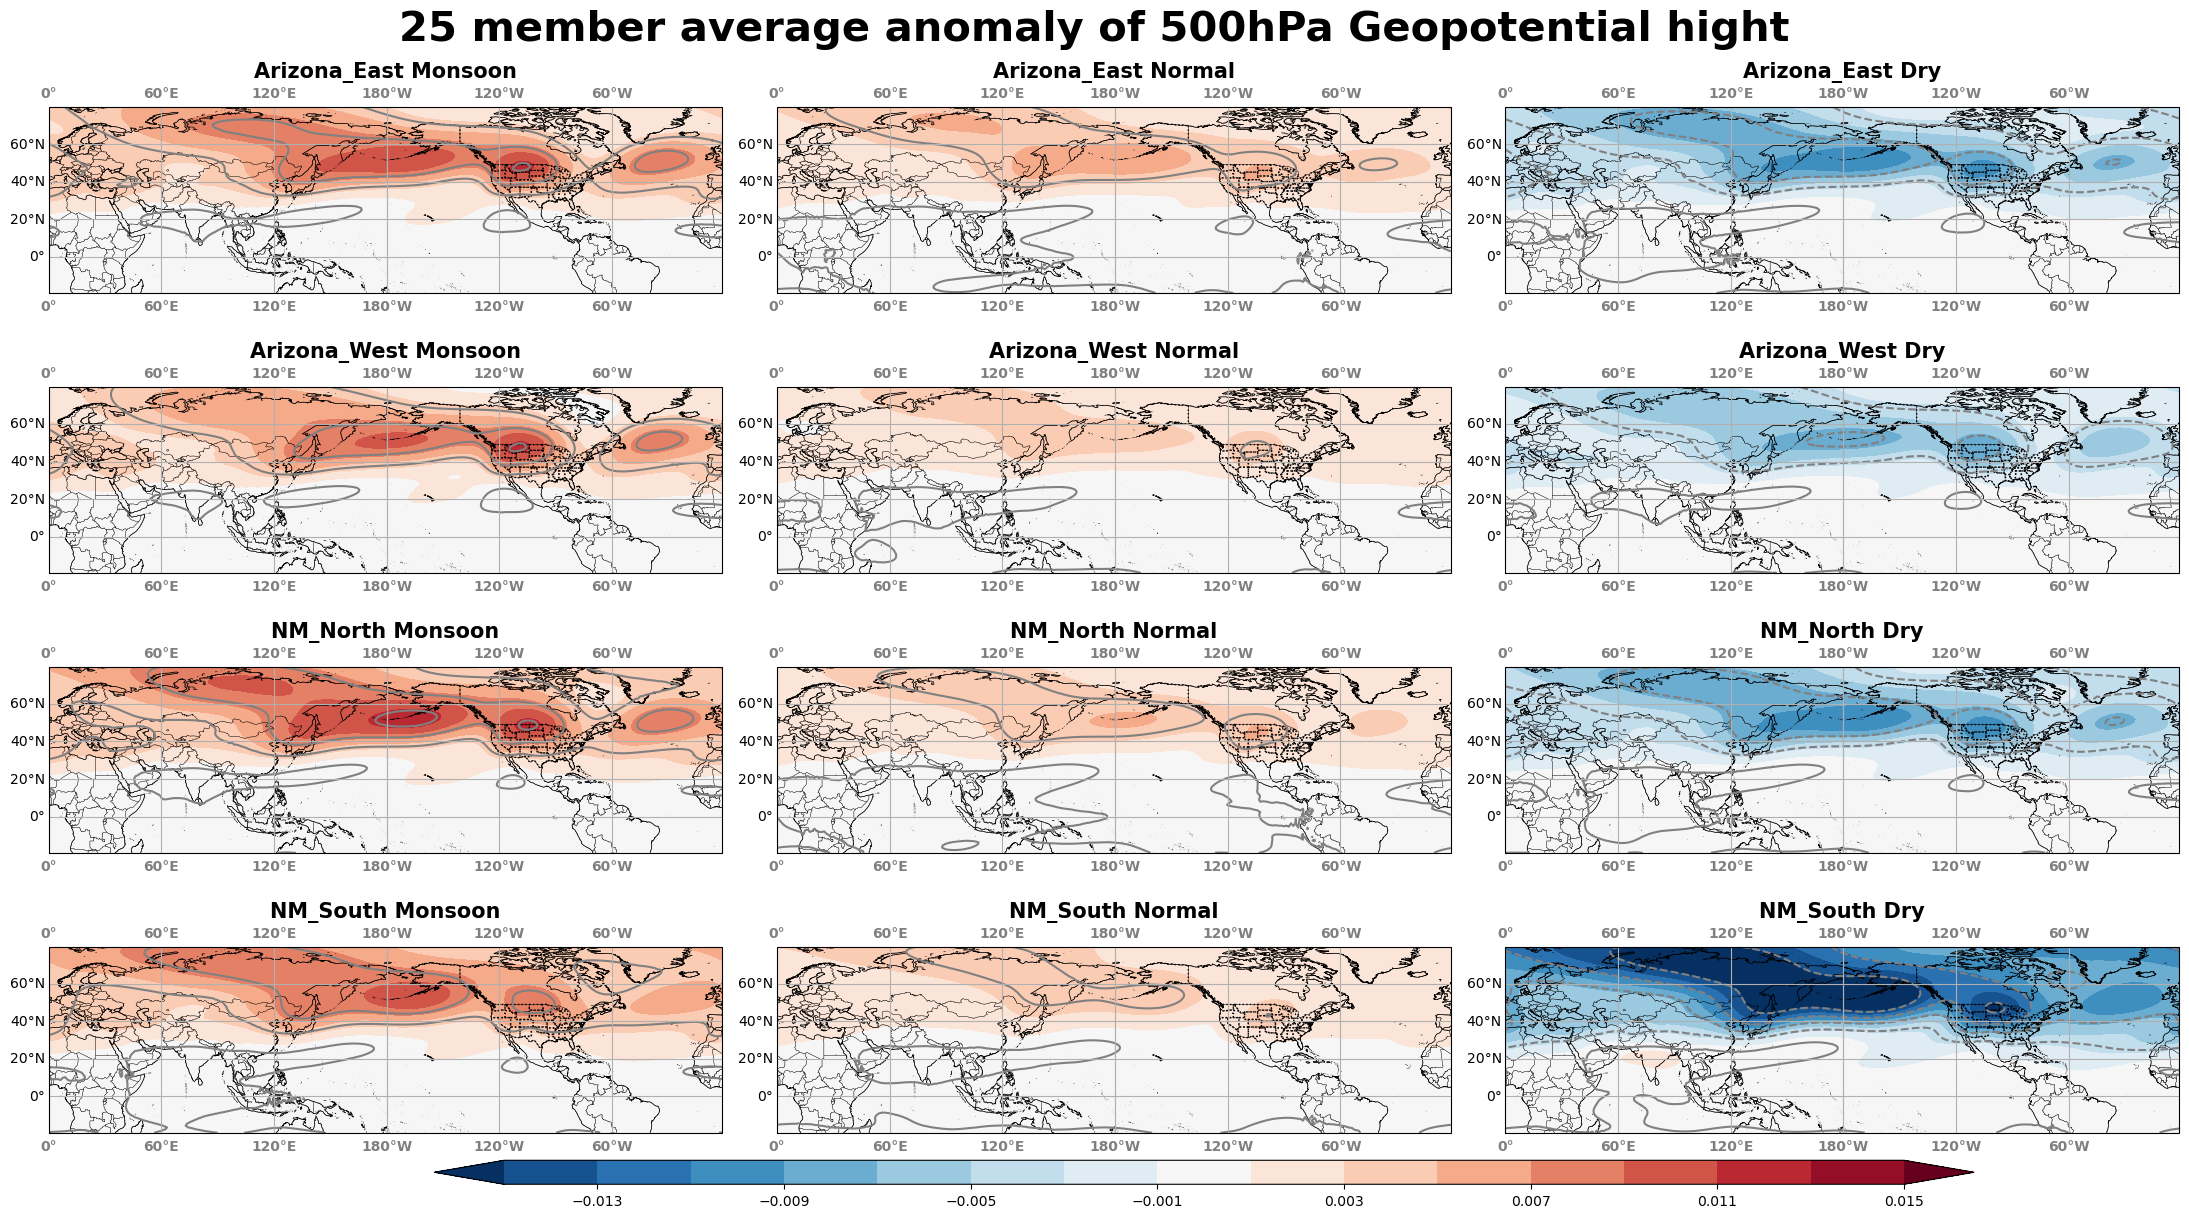

In [12]:
plot_S2Swt_12(z500_xr, -0.015, 0.015, 16, 'RdBu_r', 'horizontal', 'anomaly of 500hPa Geopotential hight')